<strong>Aluno</strong>: Victor São Paulo Ruela



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Problema Não-Linearmente Separável

Inicialmente, define-se a função geradora dos dados, conforme indicado no enunciado.

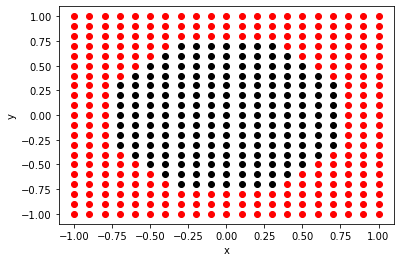

In [2]:
def func_circle(radius=0.6):
    x = np.arange(-1, 1 + 0.1, step=0.1)
    y = np.arange(-1, 1 + 0.1, step=0.1)

    xy = np.array([(xi, yi) for xi in x for yi in y])

    z = np.sum(xy ** 2, axis=1)
    z_class = 1 * (z > radius)

    df = pd.DataFrame()
    df['x'] = xy[:, 0]
    df['y'] = xy[:, 1]
    df['class'] = z_class.flatten()

    return df


def plot_func(data):
    t_class0 = data['class'] == 0
    t_class1 = data['class'] == 1

    fig, ax = plt.subplots()

    ax.scatter(data.loc[t_class0, 'x'],
                data.loc[t_class0, 'y'], color='black')
    ax.scatter(data.loc[t_class1, 'x'], data.loc[t_class1, 'y'], color='red')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return fig, ax

data = func_circle()
fig, _ = plot_func(data)
fig.show()

Conforme pode ser visto na figura acima, os dados não são linearmente separáveis. Logo, um mapeamento não-linear dever ser aplicado para que seja possível realizar sua solução em um novo espaço linearizado. 

Utilizando o Perceptron simples e uma transformação dos dados de entrada por uma função de kernel Gaussiano (RBF), é possível resolver este problema sem modificar o algoritmo. Sua implementação é feita considerando um problema de classificação binário, logo o algoritmo do gradiente descendente não será necessário.

In [3]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.01, max_epochs=300):
        self.eta = eta
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return u, 1.0 * (u >= 0)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        wk = []
        n_epochs = 0
        e_vec = []

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            error_array = []

            for i_rand in xseq:
                yhati = 1.0 * ((x_aug[i_rand, :] @ wt) >= 0)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw
                
                wk.append(wt)
                error_array.append(ei ** 2)

            # increment number of epochs
            n_epochs = n_epochs + 1
            e_vec.append(np.sum(error_array) / N)

        return wt, e_vec, wk

Em seguida, é criada uma rotina que recebe um conjunto de dados de entrada e desenha a superfície de decisão aprendida para o modelo.

In [4]:
def plot_decision_boundary(data, kernel=None):
    fig, ax = plt.subplots()

    x = np.arange(-1, 1 + 0.1, step=0.01)
    y = np.arange(-1, 1 + 0.1, step=0.01)

    xx, yy = np.meshgrid(x, y)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    if kernel != None:
        r1, r2 = kernel(r1), kernel(r2)
  
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    
    # train the model
    model = LinearPerceptron()
    y_train = data['class'].to_numpy()
    x_train = data[['x', 'y']].to_numpy()
    if kernel != None:
        x_train = kernel(x_train)

    w, e, wk = model.train(x_train, y_train)

    # make predictions for the grid
    _, yhat = model.predict(grid, w)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    ax.contourf(xx, yy, zz, cmap='Paired')
   
    t_class0 = data['class'] == 0
    t_class1 = data['class'] == 1
    ax.scatter(data.loc[t_class0, 'x'],
                data.loc[t_class0, 'y'], cmap='Paired')
    ax.scatter(data.loc[t_class1, 'x'], data.loc[t_class1, 'y'], cmap='Paired')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # calculate training error
    fig, ax = plt.subplots()
    ax.plot(e)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error')

    # print final training error
    print(f'Model Accuracy: {100 * np.sum(y_train == model.predict(x_train, w))/len(y_train)} %')

Como exercício, primeiro tentamos aprender um modelo usando diretamente os dados na sua forma original. Conforme esperado, o Perceptron simples é incapaz de aprender a superfície de separação correta para esses dados, conforme pode ser visto nas figura abaixo. Observando o erro de treinamento ao longo das épocas, nota-se uma grande variação dos valores e que não há convergência para um determinado conjunto de pesos. 

Model Accuracy: 52.38095238095238 %


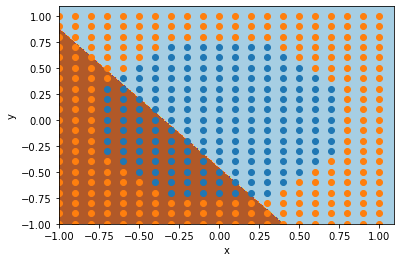

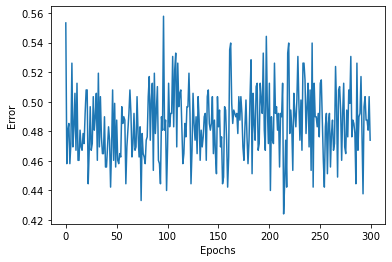

In [5]:
# Linear perceptron
plot_decision_boundary(data)


Podemos, portanto, aplicar uma transformação Gaussiana nos dados por meio de um Kernel RBF:

$$h(x, \mu_i, r) = e^{-(x-\mu_i)^2/2r^2}$$

O valor da média $\mu_i$ é zero e o raio $r$ 0.6, uma vez que conhecemos a função geradora dos dados. 

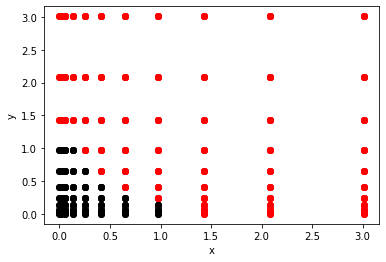

In [6]:
radius = 0.6 # using the same radius used to generate the data
def rbf(x): return np.expm1((x ** 2) / (2*(radius**2)))

xrbf = rbf(data[['x','y']].to_numpy())
data_rbf = pd.DataFrame()
data_rbf['x'] = xrbf[:, 0]
data_rbf['y'] = xrbf[:, 1]
data_rbf['class'] = data['class']

fig, _ax = plot_func(data_rbf)
fig.show()

No gráfico acima, nota-se que os dados são facilmente separados pelo Perceptron simples neste espaço linearizado. Se executarmos a mesma rotina anterior, porém considerando os dados transformados, é possível chegar à superfície de decisão esperada no espaço original, conforme exibido na figura abaixo.

Note que o erro converge rapidamente para uma determinada faixa e que é possível encontrar uma superfície de separação bem próxima da real.

Model Accuracy: 98.1859410430839 %


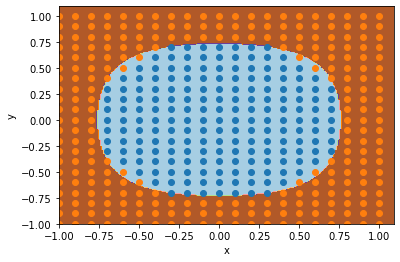

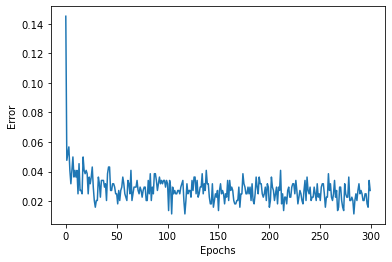

In [7]:
# Train RBF (Gaussian) kernel
plot_decision_boundary(data, rbf)

## Overfitting e Underfitting

a) Dado que foi informado que os dados da função geradora são ruidosos, é possível concluir que o modelo azul será o mais adequado. O modelo preto representa o overfitting, uma vez que ele também está descrevendo o ruído introduzido, o que não é desejado. Já o modelo vermelho representa o underfitting, pois o modelo escolhido é muito simples em relação a função geradora e não consegue a descrever com fidelidade.

b) O modelo preto apresenta o menor erro de treinamento. Ele não é adequado pois não generaliza muito bem os dados, configurando um overfitting em relação a eles. Dessa forma, ele não irá conseguir prever com qualidade novos dados não observados se esta aproximação for utilizada.

c) O modelo preto terá a maior complexidade, ou seja, possuirá o maior grau em relação aos demais. O modelo vermelho é o de menor complexidade e possui o menor grau. O modelo azul, por apresentar um resultado de compromisso entre erro e variância, terá uma complexidade intermediária, com um polinômio de grau entre o modelo preto e vermelho. 

## Aproximação polinomial

In [35]:
# Implementação do modelo de regressao polinomial
class PolynomialRegression:
    def __init__(self):
        pass

    def power(self, x, p): 
        return [x ** (p-i) for i in range(p + 1)]

    def predict(self, x, w, p):
        H = np.array(self.power(x, p)).T
        yp =  H @ w
        return yp

    def fit(self, x_train, y_train, p):
        # apply power function
        H = np.array(self.power(x_train, p)).T
        # solve
        w = np.linalg.pinv(H) @ y_train
        
        return w

# função geradora dos dados
def generator_func(N, sigma=4):
    xs = np.linspace(-15, 10, N)
    ys = (xs**2)/2 + 3*xs + 10 + np.random.randn(N)*(sigma**2)
    return xs, ys

# Função que gera os dados e calcula os polinomios até o grau maximo especificado
def fit_polynomials(N_train,  p_range, N_test = 500):
    x, y = generator_func(N_train)
    x_r, y_r = generator_func(N_test, 0) # no error, real function
    
    model = PolynomialRegression()
    l = len(p_range)

    fig, ax = plt.subplots(2, int(l/2), figsize=(16,10))

    for k, p in enumerate(p_range):    
        w = model.fit(x,y,p)
        yp_r = model.predict(x_r, w, p)

        j = int(k % (l/2))
        i = int(np.floor(k/(l/2)))

        ax[i, j].plot(x, y, 'ko')
        ax[i, j].plot(x_r, y_r, 'b-')
        ax[i, j].plot(x_r, yp_r, 'r--')
        ax[i, j].legend(['$f_{geradora}(x)$', '$f_{real}(x)$', f'$f_{p}(x)$'])
        ax[i, j].set_title(f'p = {p}')
        ax[i, j].set_xlabel('x')
        ax[i, j].set_ylabel('y')

    fig.show()

Realizando aproximações polinomiais para 10 amostras, variando o grau máximo do polinômio de $p=1$ até $p=8$, os resultados podem ser vistos na figura abaixo.

É possível ver que o underfitting ocorre somente para o grau $p=1$, uma vez que ele é caracterizado por uma reta e a função geradora é quadrática. De $p=2$ até $p=5$, os resultados são bem similares e não há uma caracterização visível de overfitting. A parti de $p=6$, o overfitting começa a ser mais evidente, uma vez o polinômio estimado está passando em cima de todos os dados usados para treinamento, exibindo erro mínimo nesta situação.

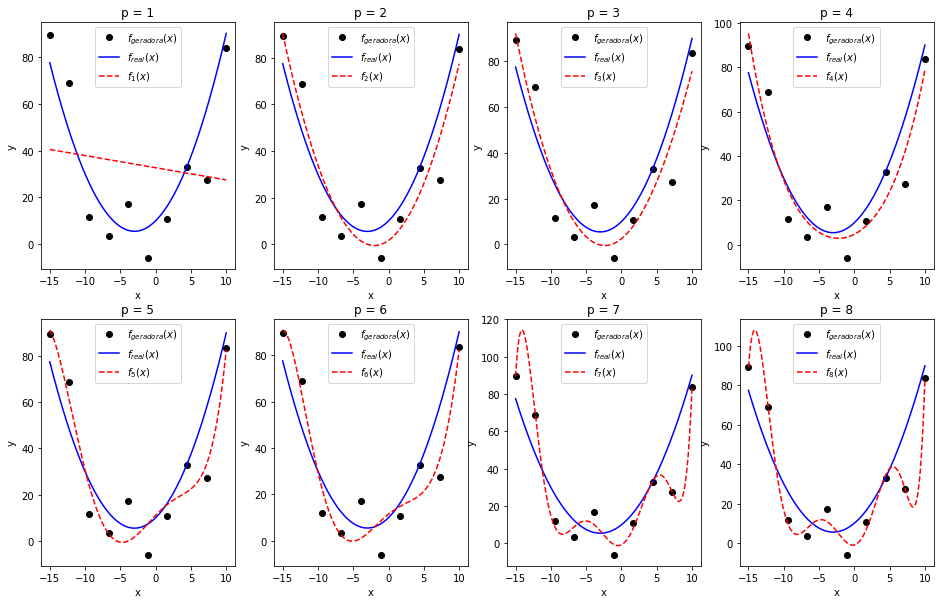

In [36]:
N_train = 10
p_range = range(1, 9)
fit_polynomials(N_train, p_range)

Repetindo o mesmo experimento, porém considerando agora 100 amostras da função geradora, os resultados podem ser vistos na figura abaixo. É interessante notar que com o aumento do número de dados, o overfitting não ficou muito evidente em relação a quando o número de amostras era baixo. Isso sugere que um grau $p=8$ não é suficiente para causar overfitting com um volume maior de dados, sendo capaz de capturar melhor o comportamente médio dos dados. 

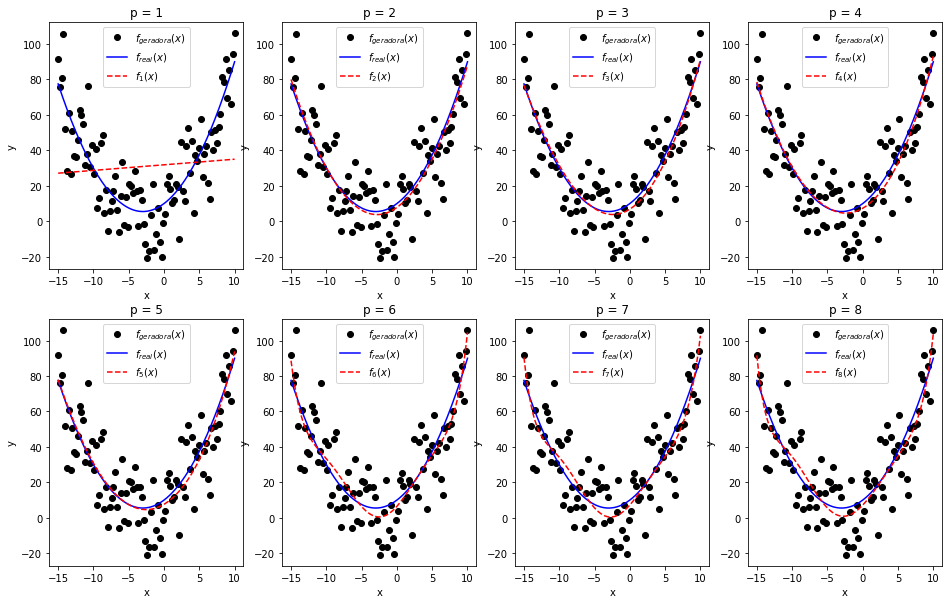

In [37]:
N_train = 100
p_range = range(1, 9)
fit_polynomials(N_train, p_range)